# Trying Ensembling

In [148]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import xgboost as xgb
from xgboost import plot_tree

from sklearn.metrics import accuracy_score

In [128]:
train_df = pd.read_csv('../data/Final Data/training_with_preds.csv')
train_df = train_df.reset_index(drop=True)
train_df_orig = train_df.copy()

In [129]:
test_df = pd.read_csv('../data/Final Data/start_to_finish_with_preds.csv')
test_df_orig = test_df.copy()

### Preprocess Data

Getting it ready to train and keeping only the rows where 2/3 or more of the models get it wrong.

In [130]:
xgb_train_pred = train_df.xgb_train_pred
knn_no_bat_train_pred = train_df.knn_no_batting_train_pred
nn_train_pred = train_df.nn_train_pred

xgb_train_pred = xgb_train_pred.astype(int)
knn_no_bat_train_pred = knn_no_bat_train_pred.astype(int)

In [131]:
train_df['add'] = train_df['xgb_train_pred'] + train_df['knn_no_batting_train_pred'] + train_df['nn_train_pred']

In [132]:
conditions = [(train_df['add'] >= 2) & (train_df['home_win'] == 1) | (train_df['add'] < 2) & (train_df['home_win'] == 0)]     #Sets the conditions
choices = [1]
train_df['should_drop'] = np.select(conditions, choices, 0)

In [133]:
train_df = train_df[train_df['should_drop'] != 1]

### Training Model

In [135]:
cols_to_drop = ['home_team', 'away_team', 'should_drop', 'xgb_train_pred', 'nn_train_pred', 'knn_no_batting_train_pred', 'add'] + ['xgb_pred', 'nn_pred', 'knn_pred', 'knn_no_batting_pred', 'xgb_proba', 'nn_proba', 'knn_proba','knn_no_batting_proba', 'home_team', 'away_team']
train_cols_to_drop = list(set(train_df.columns).intersection(set(cols_to_drop)))
test_cols_to_drop = list(set(test_df.columns).intersection(set(cols_to_drop)))

train_df = train_df.drop(train_cols_to_drop, axis=1)
test_df = test_df.drop(test_cols_to_drop, axis=1)

In [136]:
common_cols = list(set(train_df.columns).intersection(set(test_df.columns)))

test_df = test_df[common_cols]
train_df = train_df[common_cols]

In [137]:
X_train = train_df.drop('home_win', axis=1)
y_train = train_df.home_win.astype(int)
X_test = test_df.drop('home_win', axis=1)
y_test = test_df.home_win.astype(int)

In [139]:
params = {'n_estimators': 100,
         'max_depth': 5,
         'min_child_weight': 0.3256355793000354,
         'eta': 0.3076951770384403,
         'subsample': 0.8242904472901268,
         'colsample_bytree': 0.9475703665037462,
         'gamma': 9.66425615956974,
         'seed': 0,
         'nthread': 4,
         'objective': 'binary:logistic',
         'eval_metric': 'auc'}

xgb_clf = xgb.XGBClassifier(**params)

xgb_clf.fit(X_train, y_train)

/Users/psavala/.virtualenvs/baseball/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9475703665037462,
              eta=0.3076951770384403, eval_metric='auc', gamma=9.66425615956974,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.30769518, max_delta_step=0, max_depth=5,
              min_child_weight=0.3256355793000354, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4, nthread=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=0, subsample=0.8242904472901268,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [140]:
preds = xgb_clf.predict(X_test)

In [141]:
accuracy_score(y_test, preds)

0.3716039444556249

In [142]:
featuredf = pd.DataFrame(xgb_clf.feature_importances_, X_train.columns)   #This makes it in order
featuredf = featuredf.sort_values(by=0, ascending=True)

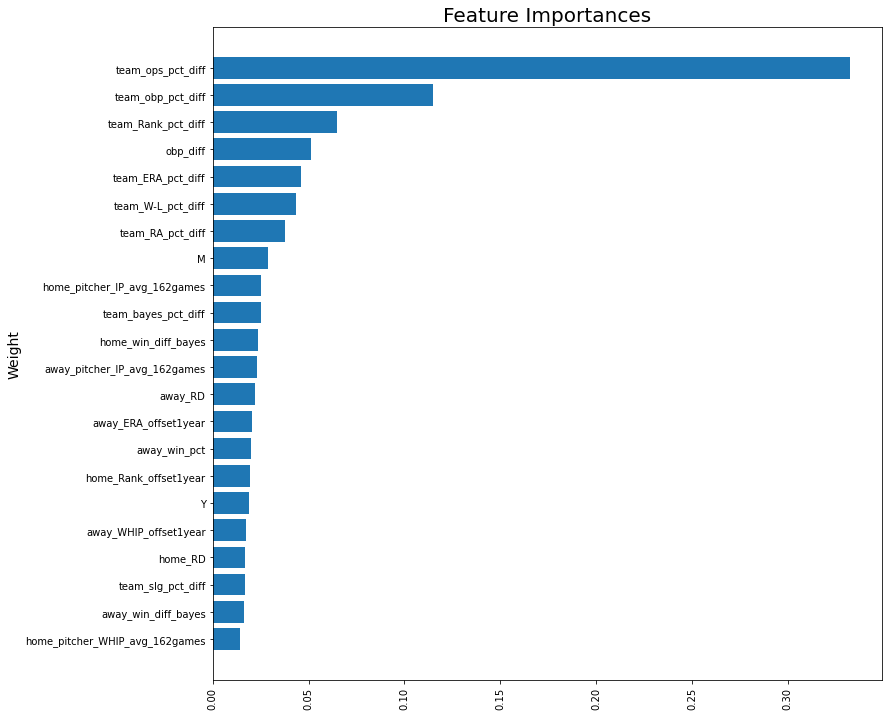

In [143]:
plt.figure(figsize=(12, 12))

x = featuredf.index
y = featuredf[0]

plt.barh(x, y)
plt.xticks(rotation=90)
plt.title('Feature Importances', fontsize=20)
plt.ylabel('Weight', fontsize=14);

In [ ]:
new_right_old_wrong_df = test_df_orig[(test_df_orig['xgb_pred'] != preds)&(test_df_orig['home_win']==preds)]

for c in new_right_old_wrong_df.columns:
    home_win = new_right_old_wrong_df[new_right_old_wrong_df['home_win'] == 1]
    home_loss = new_right_old_wrong_df[new_right_old_wrong_df['home_win'] == 0]
    
    

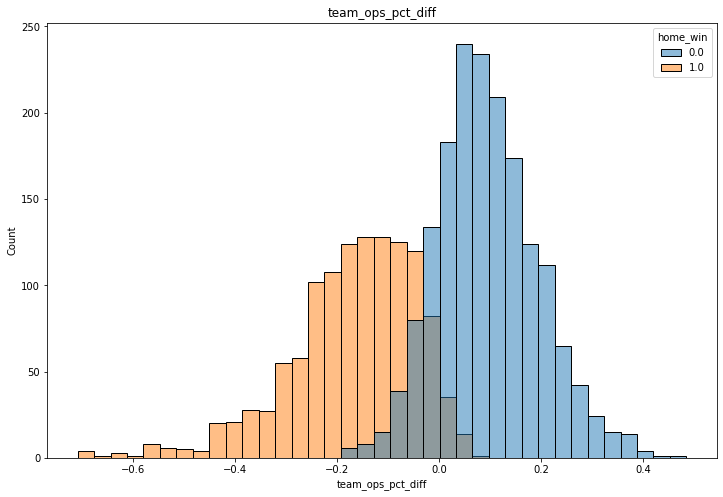

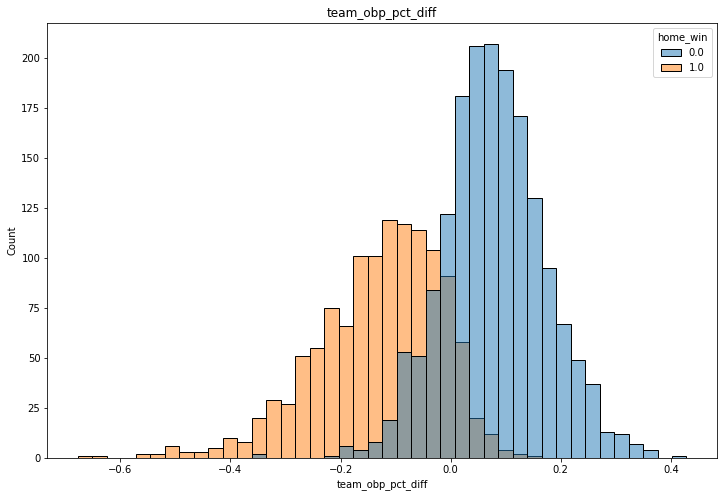

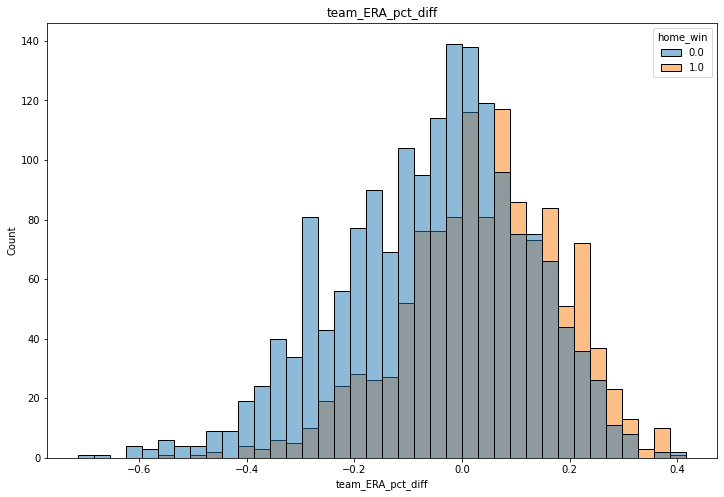

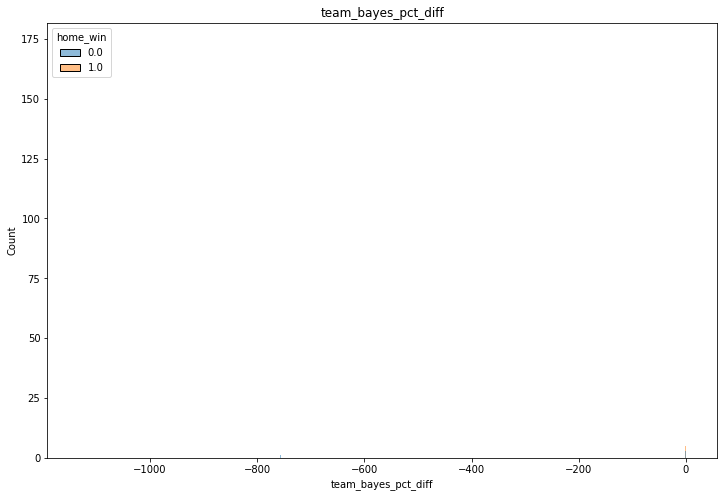

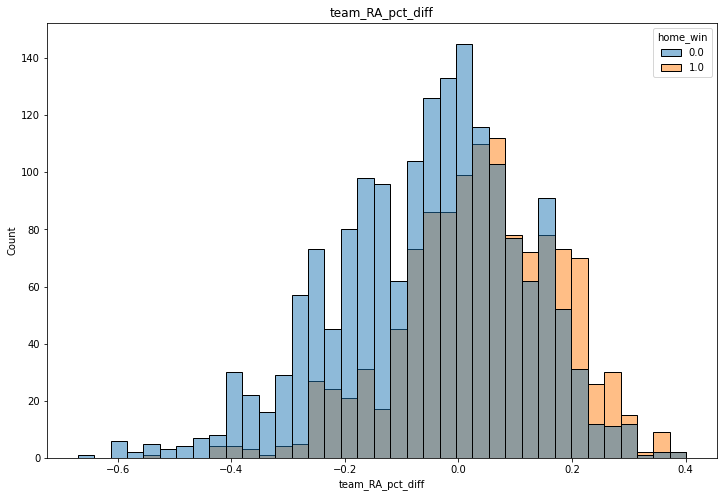

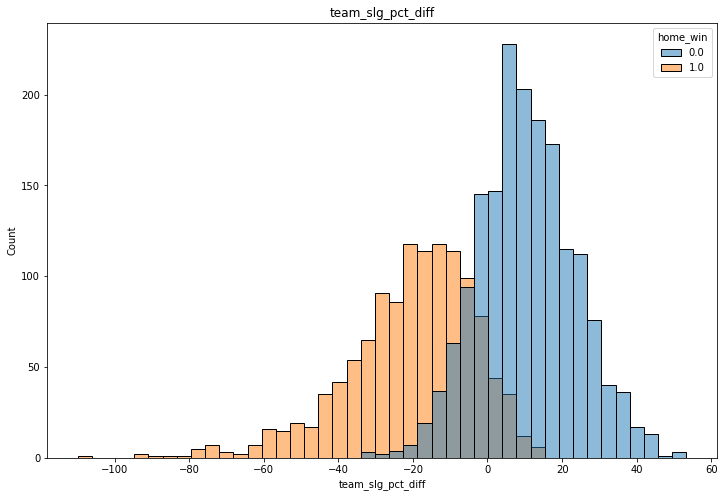

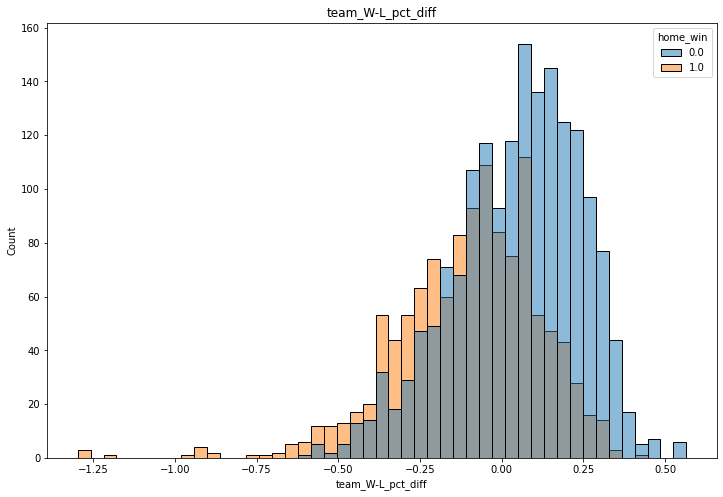

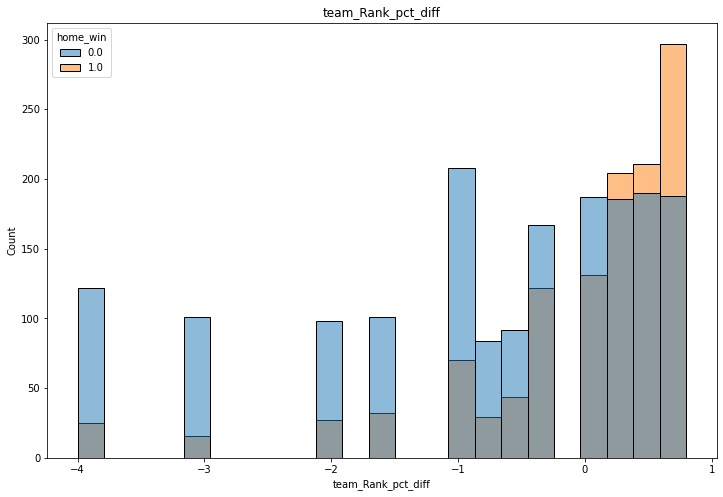

In [162]:
pct_diff_cols = [c for c in test_df_orig.columns if c.endswith('_pct_diff')]

for col in pct_diff_cols:
    plt.figure(figsize=(12, 8))
    sns.histplot(data=test_df_orig[(test_df_orig['xgb_pred'] != preds)&(test_df_orig['home_win']==preds)],
                 x=col,
                 hue='home_win')
    plt.title(col)
    plt.show()

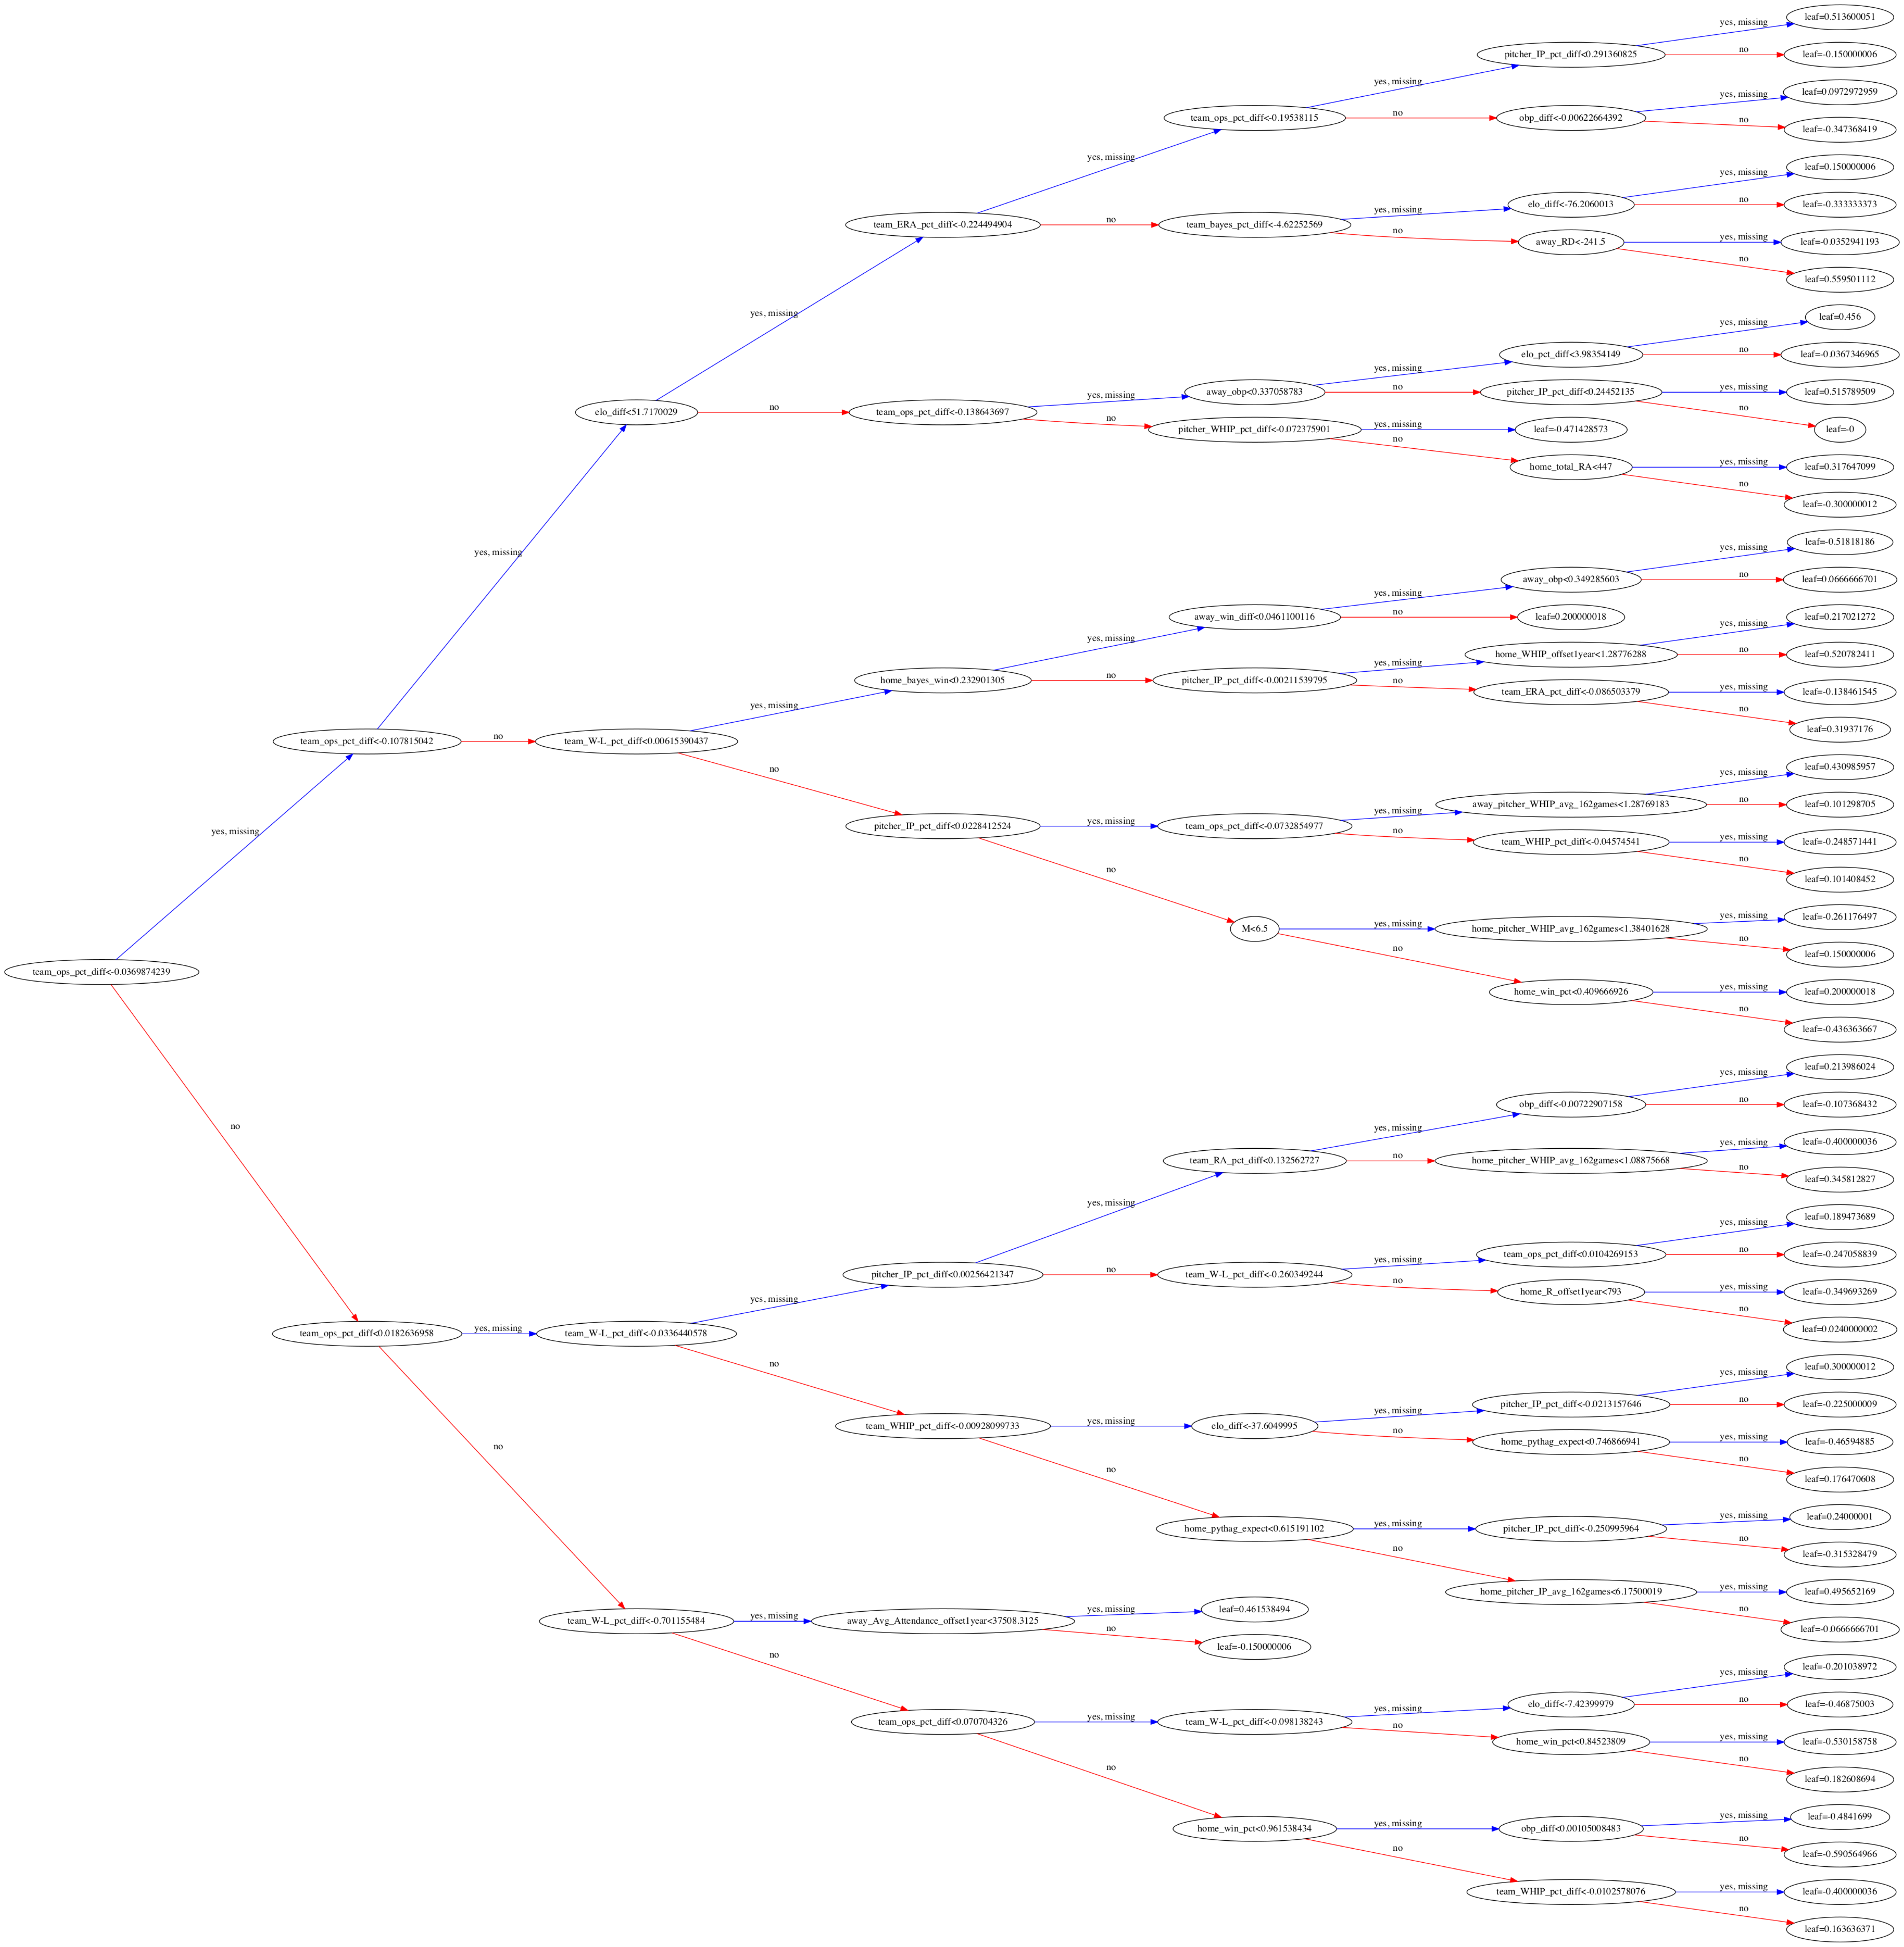

In [40]:
plot_tree(xgb_model, rankdir='LR')
fig = plt.gcf()
fig.set_size_inches(200, 125)
plt.show()

### Regular Model

In [41]:
df = pd.read_csv('../data/Final Data/start_to_finish.csv') 

train_df = df[df['Y'] <= 2015]
test_df = df[df['Y'] > 2015]

X_train = train_df.drop('home_win', axis=1)
y_train = train_df.home_win

X_test = test_df.drop('home_win', axis=1)
y_test = test_df.home_win

In [42]:
def fill_na_inf(df):
    for c in df.columns:
        if df[c].isin([-np.inf, np.inf]).sum() > 0:
            df[c] = df[c].replace([-np.inf, np.inf], None)
        if df[c].isna().sum() > 0:
            med = df[c].median()
            df[c] = df[c].fillna(med)
    return df

In [43]:
train_df = fill_na_inf(train_df)
test_df = fill_na_inf(test_df)

X_train = fill_na_inf(X_train)
X_test = fill_na_inf(X_test)

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [44]:
X_train = X_train.drop(['home_team', 'away_team'], axis='columns')
X_test = X_test.drop(['home_team', 'away_team'], axis='columns')

train_df = train_df.drop(['home_team', 'away_team'], axis='columns')
test_df = test_df.drop(['home_team', 'away_team'], axis='columns')

In [45]:
params = {'n_estimators': 100,
         'max_depth': 5,
         'min_child_weight': 0.3256355793000354,
         'eta': 0.3076951770384403,
         'subsample': 0.8242904472901268,
         'colsample_bytree': 0.9475703665037462,
         'gamma': 9.66425615956974,
         'seed': 0,
         'nthread': 4,
         'objective': 'binary:logistic',
         'eval_metric': 'auc'}

In [46]:
xgb_clf_normal = xgb.XGBClassifier(**params)

In [47]:
xgb_normal_model = xgb_clf_normal.fit(X_train, y_train)

/opt/miniconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [49]:
xgb_normal_preds = xgb_clf_normal.predict(X_test)

test_acc = accuracy_score(y_test, xgb_normal_preds)
print(f'Test acc = {100*test_acc:.2f}%')

Test acc = 61.08%


In [50]:
plot_tree(xgb_normal_model, rankdir='LR')
fig = plt.gcf()
fig.set_size_inches(200, 125)
plt.show()